## Variable importance in uplift modelling

In [1]:
from profiles import train, X_train, Y_train, X_valid, Y_valid, column_names, treatment_col
from model import train_xgb_model, train_logistic, evaluate_uplift, simple_network, check_acc_diff, check_uplift_diff, local_search_xgb
from explanations import shapley_importance_plot
train.head()

Dataset bias: 14.677734375000002% of positive answers 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
recency                 64000 non-null int64
history                 64000 non-null float64
mens                    64000 non-null int64
womens                  64000 non-null int64
zip_code_Surburban      64000 non-null int64
zip_code_Rural          64000 non-null int64
zip_code_Urban          64000 non-null int64
newbie                  64000 non-null int64
channel_Phone           64000 non-null int64
channel_Web             64000 non-null int64
channel_Multichannel    64000 non-null int64
segment                 64000 non-null int64
dtypes: float64(1), int64(11)
memory usage: 5.9 MB


recency  history  mens  womens  zip_code_Surburban  zip_code_Rural  \
0       10   142.44     1       0                   1               0   
1        6   329.08     1       1                   0               1   
2        7   180.65     0       1                   1               0   
3        9   675.83     1       0                   0               1   
4        2    45.34     1       0                   0               0   

   zip_code_Urban  newbie  channel_Phone  channel_Web  channel_Multichannel  \
0               0       0              1            0                     0   
1               0       1              0            1                     0   
2               0       1              0            1                     0   
3               0       1              0            1                     0   
4               1       0              0            1                     0   

   segment  
0        1  
1        0  
2        1  
3        1  
4        1

This is an uplift modelling dataset with indicator variable TREATMENT coded as segment here, orignally consisting of 3 types - no communication, mens and womans communicator type. Here, for simplicity the latter two are merged into one (because we already have information about gender in other column). 
Columns represent (after feature eng):

- recency - Months since last purchase.
- history - Actual dollar value spent in the past year.
- mens - customer purchased Mens merchandise in the past year
- womens -  customer purchased Womens merchandise in the past year
- zip_code_Surburban - 0/1 indicator if suburban
- zip_code_Rural - 0/1 indicator if rural
- zip_code_Urban - 0/1 indicator if urban
- newbie - 1 if new customer in the past twelve months
- channel_Phone - purchased by phone
- channel_Web - puchased by web
- channel_Multichannel - above or more channels

It's easy to see, that above variables are surely highly corelated (history > 0 <-> newbie etc.). Some other variables were therefore removed.

## Models and their scores

### Robust XGBoost

Robust XGBoost train acc: 0.85322265625
Robust XGBoost valid acc: 0.853203125
Robust XGBoost train uplift score = 0.03989780863901681
Robust XGBoost valid uplift score = 0.04252811281452567


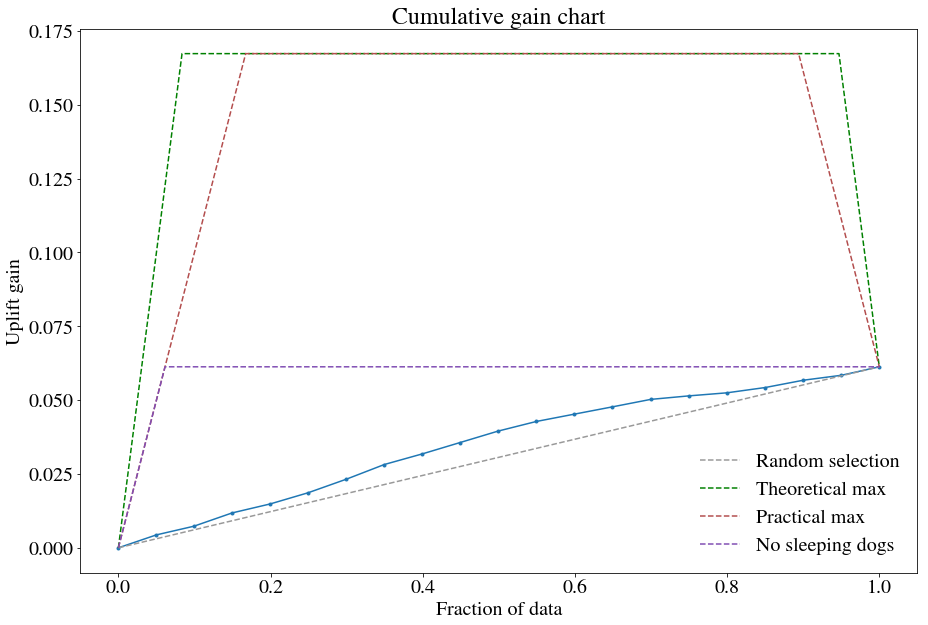

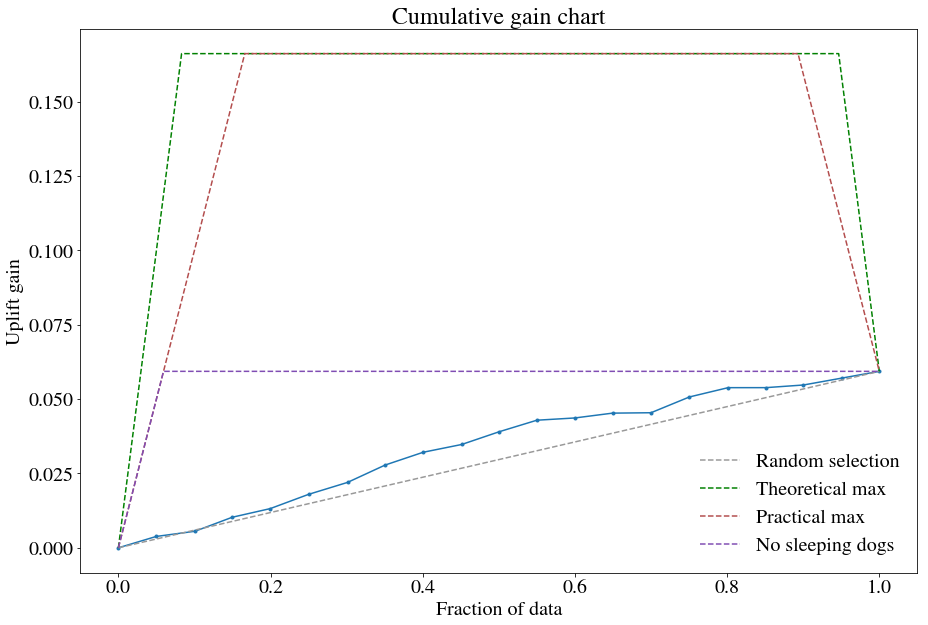

In [2]:
r_xgb_model = local_search_xgb(X_train, Y_train, X_valid, Y_valid, treatment_col, just_get_model=True)
check_acc_diff(r_xgb_model, "Robust XGBoost", X_train, Y_train, X_valid, Y_valid)
check_uplift_diff(r_xgb_model, "Robust XGBoost", X_train, Y_train, X_valid, Y_valid, treatment_col)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


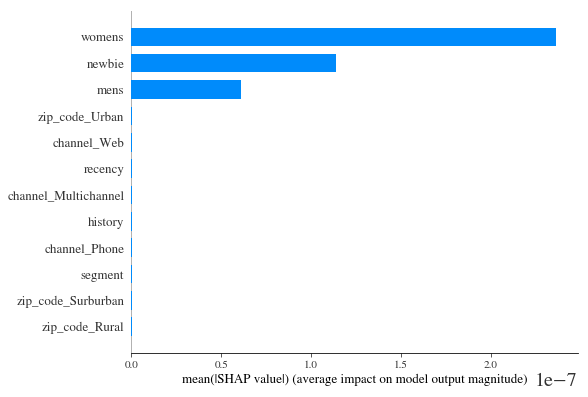

In [3]:
shapley_importance_plot(r_xgb_model, X_valid, column_names, treatment_col)

This is model found by hyper-parameters local search: Approximate local derivative of each hyper-parameter by sampling close values, cross-validate model with them and then go ascending way, loop over all parameters for some iterations until no change appears what means we hit local minimum. Models found by this method are highly robust, and as we see the scores on train and valid datasets are close (actually, here because of some random fluctuations, valid have better score). However, this cross-validation did not use accuracy or loss as metric, but had to use adjusted gains, calculated as gain of current model comparing to random model, normalized by maximum possible achievable score (visible on above plots respectively for train and valid dataset). This parameter can be also interpreted as a relative monetary profit from using this algorithm instead of random one.

However whats suprising, this model only depdends on 3 variables; if client bought some "mens" merchandise, "womans" merchandise and if is new to this shop. Considering the model uses decision trees, its highly probable that it completly does not use other parameters. This shows how simple is has to be (its only 8 possibilities of three binary variables, which could be implemented as "buckets" for which we return estimated value from the data), and probably any other option was leading to overfit. 

### Overfitted XGBoost

Overfitted XGBoost train acc: 0.875546875
Overfitted XGBoost valid acc: 0.84734375
Overfitted XGBoost train uplift score = 0.7190484104514848
Overfitted XGBoost valid uplift score = 0.02037420658358888


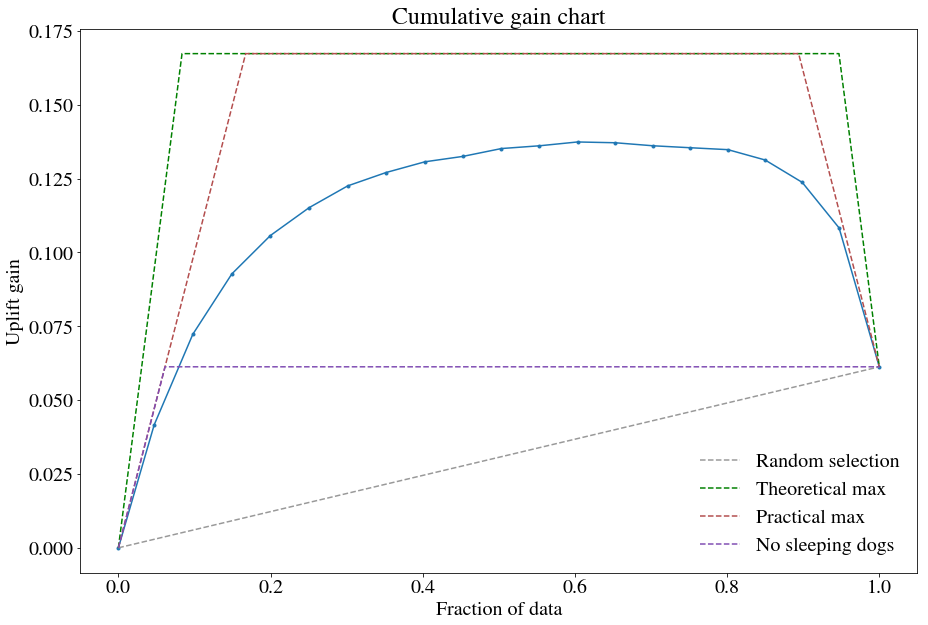

In [4]:
o_xgb_model = train_xgb_model(X_train, Y_train, X_valid, Y_valid)
check_acc_diff(o_xgb_model, "Overfitted XGBoost", X_train, Y_train, X_valid, Y_valid)
check_uplift_diff(o_xgb_model, "Overfitted XGBoost", X_train, Y_train, X_valid, Y_valid, treatment_col)

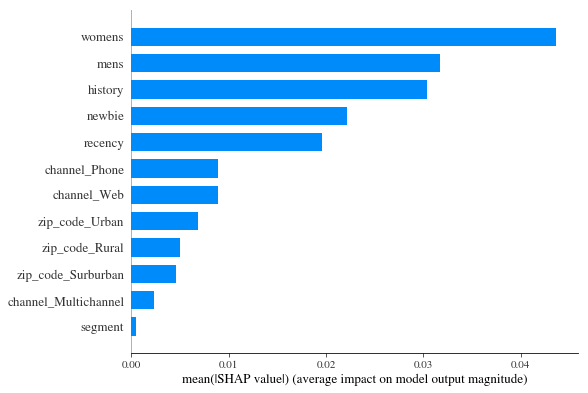

In [5]:
shapley_importance_plot(o_xgb_model, X_valid, column_names, treatment_col)

This is default version of gradient boosting classifier (one of non-optimal versions from previous local search space, but with better score on train set). The first conspicuous thing here is, how bad accuracy metric works for comparison of uplift  models! While both on train and valid set have around 85% accuracy (which is not hard remembering how biased this binary classification problem is), gain on train takes tremendous score of ~0.7, while on valid its ~0.02, two times worse then previous robust one. Another interesting thing might be, why these top 3 parameters does not match: my guess it's because history contains information about being newbie (equivalent when it's equal to 0). 

### Simple neural network

Simple neural network train acc: 0.853222668170929
Simple neural network valid acc: 0.8532031178474426
Simple neural network train uplift score = -0.01284933356834291
Simple neural network valid uplift score = -0.01913889553693524


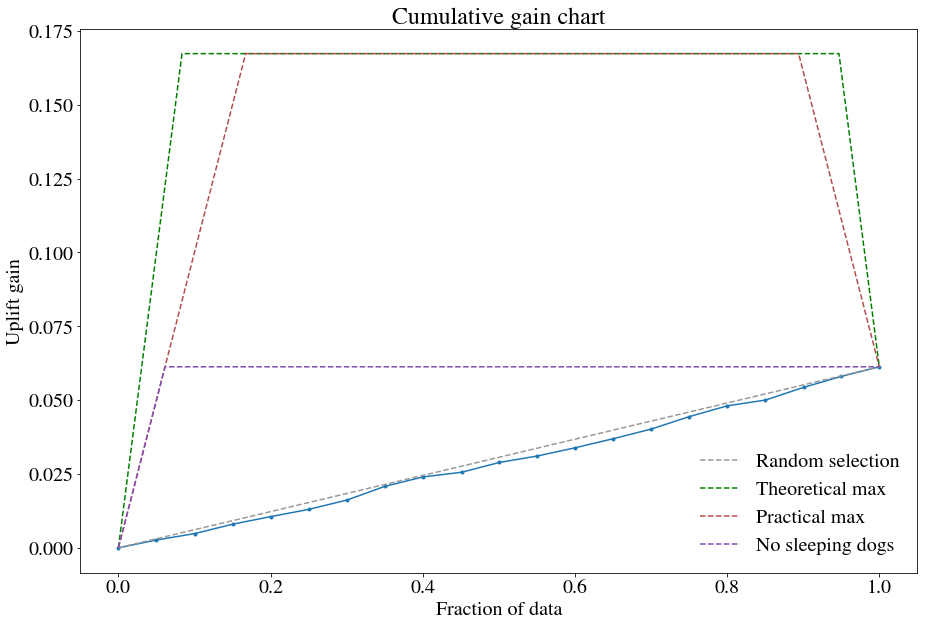

In [6]:
nn_model = simple_network(X_train, Y_train, X_valid, Y_valid)
check_acc_diff(nn_model, "Simple neural network", X_train, Y_train, X_valid, Y_valid)
check_uplift_diff(nn_model, "Simple neural network", X_train, Y_train, X_valid, Y_valid, treatment_col)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


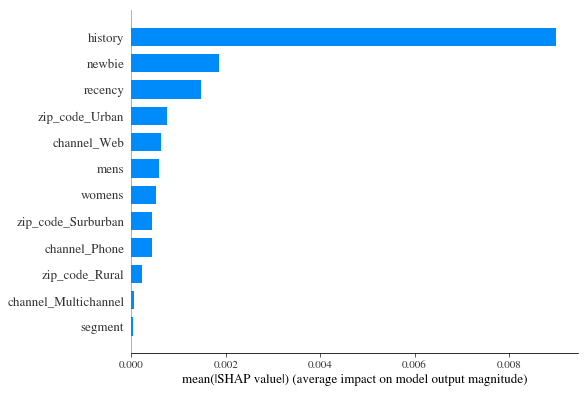

In [7]:
shapley_importance_plot(nn_model, X_valid, column_names, treatment_col)

This is overfitted small neural network model (elu, 3 layers with channels of size 50, high dropout and batchnorm, learned with early stopping based on validation dataset loss), completly unable to learn robust features. Here history is _most used_ feature, probably because it helps neural network to identify and remember certain cases because its only parameter with such variate values, what of course do not extrapolate on other datasets and provides slightly negative gain. 

### Logistic model

Logistic model train acc: 0.853203125
Logistic model valid acc: 0.85328125
Logistic model train uplift score = 0.01894758558321193
Logistic model valid uplift score = 0.02509077190747952


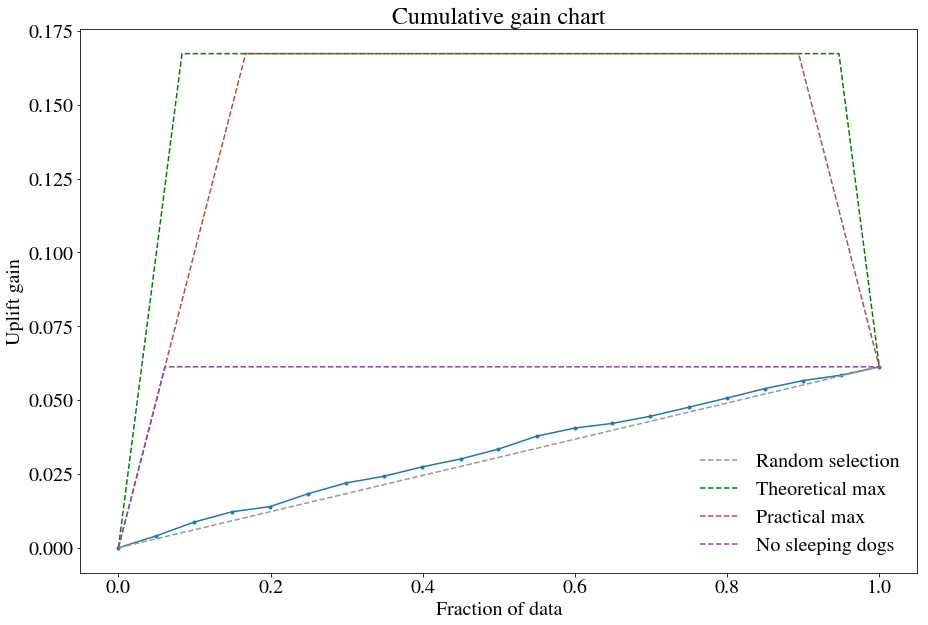

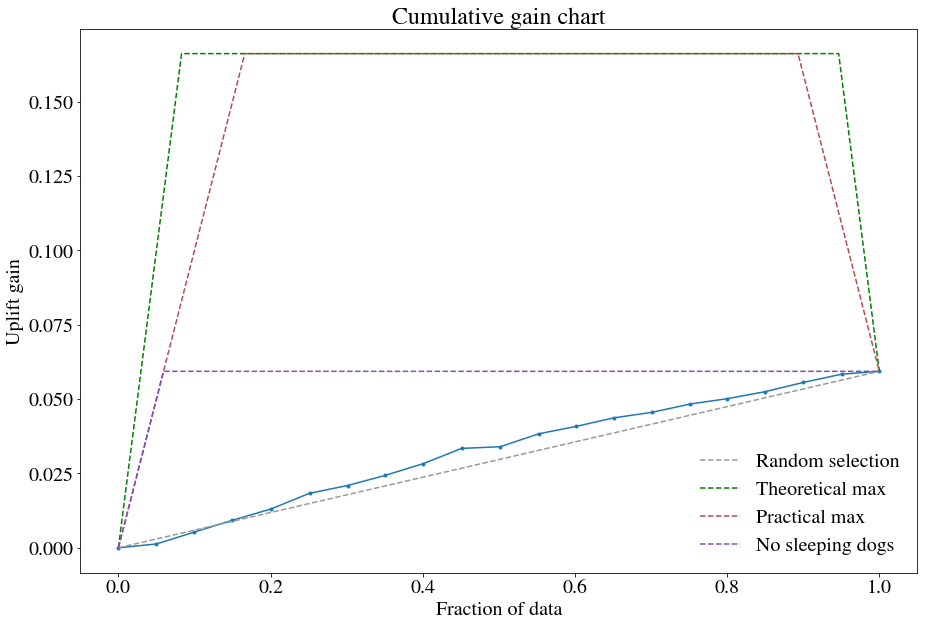

In [8]:
lr_model = train_logistic(X_train, Y_train, X_valid, Y_valid)
check_acc_diff(lr_model, "Logistic model", X_train, Y_train, X_valid, Y_valid)
check_uplift_diff(lr_model, "Logistic model", X_train, Y_train, X_valid, Y_valid, treatment_col)

In [9]:
shapley_importance_plot(lr_model, X_valid, column_names, treatment_col)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

Logistic regression here, as benchmark algorithm provides reasonable score taking into consideration its complexity. However, feature importances, equal to absolute values of parameters, much differ to previous ones, proving nonlinearity even of the first simple robust classifier. Also, because uplift score is all about corelation: ```P(B|T=1) - P(B|T=0)```, its dangerous to use linear models here, because pure linear regression  would always return just treatment coefficient. 